<a href="https://colab.research.google.com/github/siddhartha18101/Blind-Modulation-Detection/blob/master/BlindModualtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
filepath = '/content/drive/My Drive/Main/CNN_with_Keras/RML2016.10a_dict.pkl'

In [0]:

import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, sys
%matplotlib inline

In [0]:


import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam

In [0]:

Xd = cPickle.load(open('/content/drive/My Drive/Main/CNN_with_Keras/RML2016.10a_dict.pkl','rb'))

In [0]:

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [0]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [0]:
np.shape(Xd['QAM64', 0])

(1000, 2, 128)

In [0]:

def reconstructSignal(s):
    I = s[0,:]   
    Q = s[1,:]   
    n = len(I)   
    f = 10e6     
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

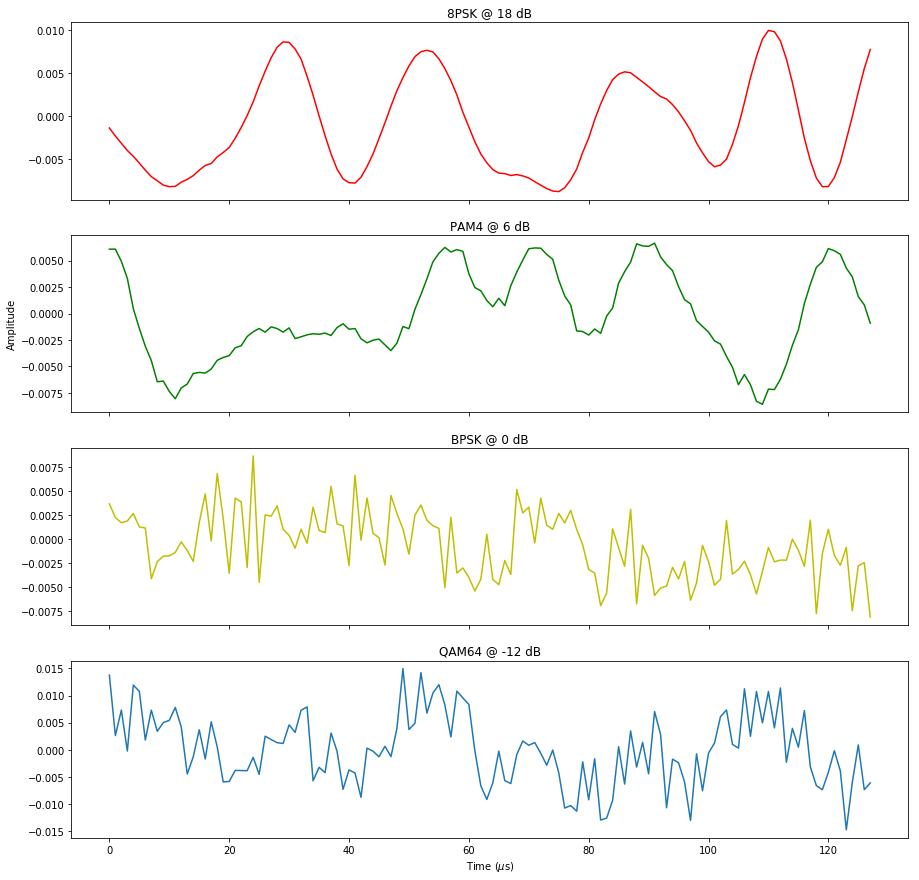

In [0]:

nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

In [0]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [0]:
np.shape(X)

(220000, 2, 128)

In [0]:
numNoiseSamples = 20000 
for i in range(numNoiseSamples): 
    lbl.append(['Noise', snrs[i%len(snrs)]])
    
mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  

In [0]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) 
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

In [0]:

np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)  


train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)


test_idx = list(set(range(0,n_examples))-set(train_idx))

X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [0]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [0]:
in_shp = list(X_train.shape[1:])   
print X_train.shape, in_shp
classes = mods

(168000, 2, 128) [2, 128]


In [0]:
from keras.layers import LSTM


dr = 0.6 
model = models.Sequential()  

model.add(Reshape(in_shp+[1], input_shape=in_shp))  


model.add(Convolution2D(16, (1, 16), padding='valid', strides=(1,2), activation="relu", name="conv1", kernel_initializer='glorot_uniform'))


model.add(Convolution2D(32, (2, 8), padding="valid", strides=(1,2),activation="relu", name="conv2", kernel_initializer='glorot_uniform'))


model.add(Convolution2D(64, (1, 4), padding="valid", activation="relu", name="conv3", kernel_initializer='glorot_uniform'))



model.add(Flatten())

model.add(Dense(512, kernel_initializer="he_normal", activation="relu", name="dense1"))

model.add(Dropout(dr))

model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense2"))

model.add(Dropout(dr))

model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense3" ))

model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

W0304 09:39:36.097860 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0304 09:39:36.108460 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0304 09:39:36.134774 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0304 09:39:36.193192 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0304 09:39:36.209836 140111760193408 module_wrapper.py:139]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 57, 16)         272       
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 25, 32)         8224      
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 22, 64)         8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               721408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________

In [0]:

nb_epoch = 50     
batch_size = 1024  

In [0]:


modelWeightsFile = filepath + '.wts.h5'  

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

model.load_weights(modelWeightsFile)

W0304 09:40:17.633670 140111760193408 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0304 09:40:17.775089 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0304 09:40:17.921271 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0304 09:40:18.318284 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Se

Train on 168000 samples, validate on 72000 samples
Epoch 1/50


W0304 09:40:18.635025 140111760193408 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



 - 42s - loss: 2.1450 - acc: 0.1979 - val_loss: 1.8251 - val_acc: 0.3020

Epoch 00001: val_loss improved from inf to 1.82508, saving model to /content/drive/My Drive/Main/CNN_with_Keras/RML2016.10a_dict.pkl.wts.h5
Epoch 2/50
 - 40s - loss: 1.8069 - acc: 0.3062 - val_loss: 1.6570 - val_acc: 0.3729

Epoch 00002: val_loss improved from 1.82508 to 1.65703, saving model to /content/drive/My Drive/Main/CNN_with_Keras/RML2016.10a_dict.pkl.wts.h5
Epoch 3/50
 - 40s - loss: 1.6406 - acc: 0.3806 - val_loss: 1.5554 - val_acc: 0.4081

Epoch 00003: val_loss improved from 1.65703 to 1.55536, saving model to /content/drive/My Drive/Main/CNN_with_Keras/RML2016.10a_dict.pkl.wts.h5
Epoch 4/50
 - 40s - loss: 1.5436 - acc: 0.4125 - val_loss: 1.4762 - val_acc: 0.4318

Epoch 00004: val_loss improved from 1.55536 to 1.47622, saving model to /content/drive/My Drive/Main/CNN_with_Keras/RML2016.10a_dict.pkl.wts.h5
Epoch 5/50
 - 40s - loss: 1.4912 - acc: 0.4291 - val_loss: 1.4730 - val_acc: 0.4294

Epoch 00005: v

In [0]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(X_test)
print()
print()
print(classification_report(np.argmax(Y_test, axis=1), y_predict))

()
()
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      5957
           1       0.48      0.73      0.58      5852
           2       0.27      0.90      0.42      5932
           3       0.88      0.58      0.70      6051
           4       0.75      0.63      0.68      5963
           5       0.76      0.65      0.70      6022
           6       1.00      1.00      1.00      6125
           7       0.90      0.68      0.77      5991
           8       0.34      0.09      0.14      5906
           9       0.52      0.70      0.59      6029
          10       0.85      0.25      0.39      6072
          11       0.80      0.11      0.19      6100

   micro avg       0.57      0.57      0.57     72000
   macro avg       0.67      0.57      0.56     72000
weighted avg       0.67      0.57      0.56     72000



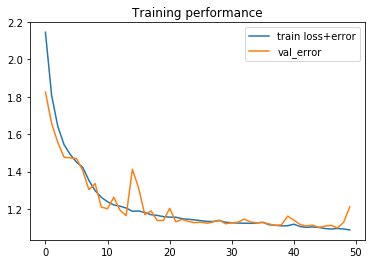

In [0]:

plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

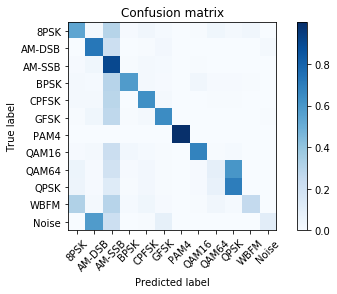

In [0]:

test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



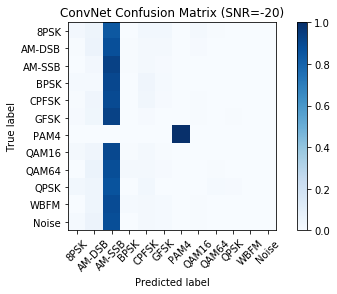

Overall Accuracy for SNR -20: 0.170718077675


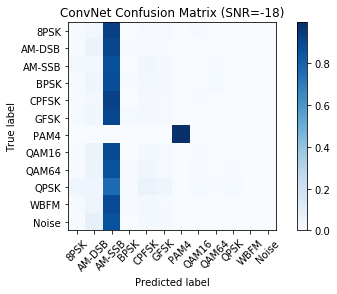

Overall Accuracy for SNR -18: 0.174743838272


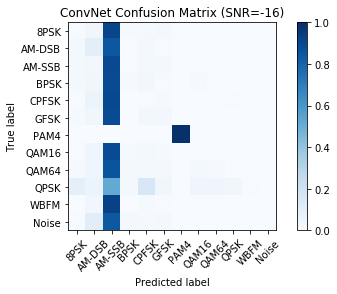

Overall Accuracy for SNR -16: 0.17901065865


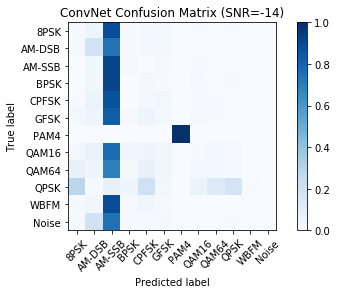

Overall Accuracy for SNR -14: 0.19701986755


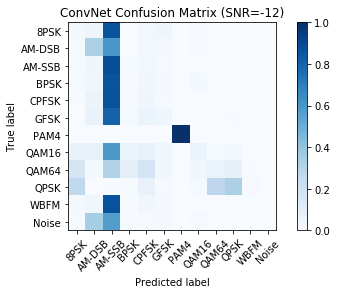

Overall Accuracy for SNR -12: 0.237404162103


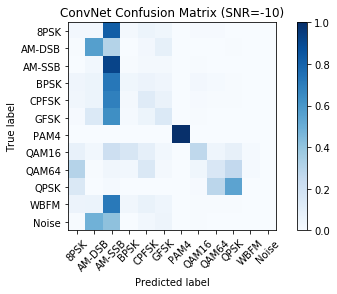

Overall Accuracy for SNR -10: 0.309820944113


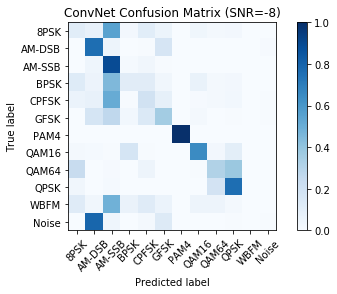

Overall Accuracy for SNR -8: 0.428894543398


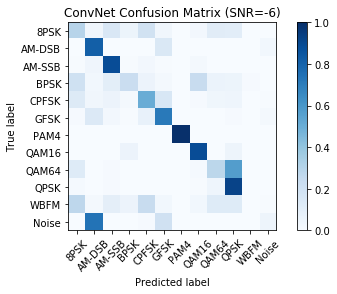

Overall Accuracy for SNR -6: 0.545759865659


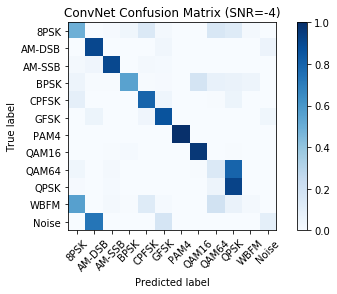

Overall Accuracy for SNR -4: 0.632989115267


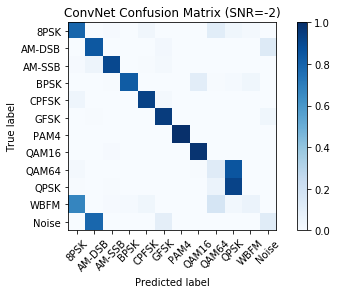

Overall Accuracy for SNR -2: 0.704908990623


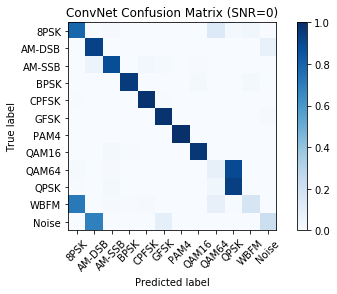

Overall Accuracy for SNR 0: 0.738607771876


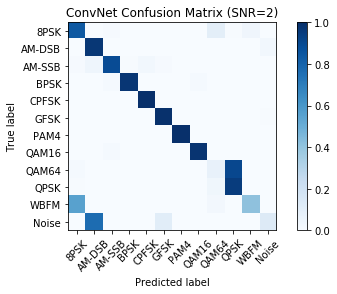

Overall Accuracy for SNR 2: 0.761570827489


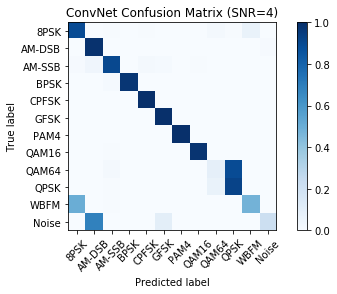

Overall Accuracy for SNR 4: 0.790470883254


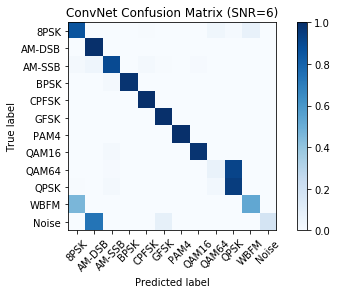

Overall Accuracy for SNR 6: 0.79210381005


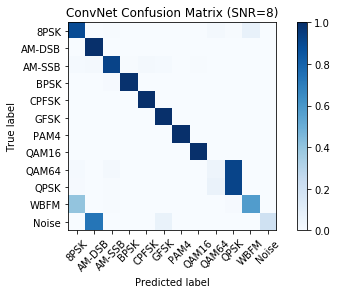

Overall Accuracy for SNR 8: 0.800391389432


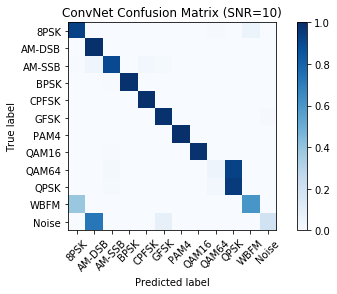

Overall Accuracy for SNR 10: 0.801662049861


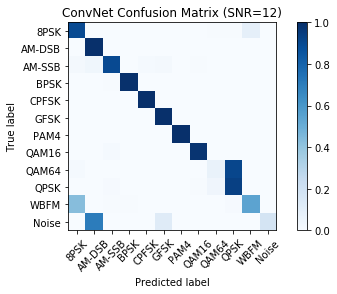

Overall Accuracy for SNR 12: 0.785594170404


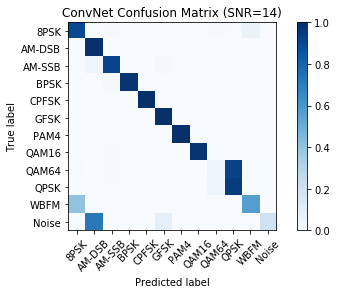

Overall Accuracy for SNR 14: 0.794092827004


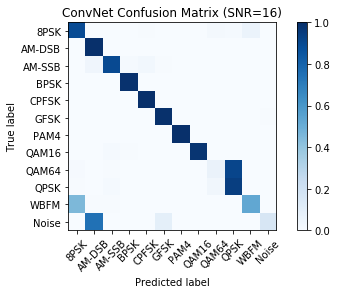

Overall Accuracy for SNR 16: 0.789125034502


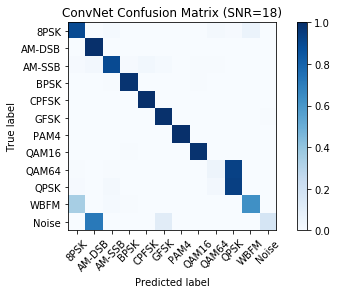

Overall Accuracy for SNR 18: 0.801618303571


In [0]:

acc = {}
for snr in snrs:

    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [0]:

print acc
fd = open(filepath + '.results.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.7386077718758737, 16: 0.789125034501794, 2: 0.761570827489481, 4: 0.7904708832543884, 6: 0.7921038100496963, 8: 0.8003913894324853, 12: 0.7855941704035875, 10: 0.8016620498614958, -20: 0.17071807767532832, 18: 0.8016183035714286, -18: 0.17474383827194684, -16: 0.17901065864990434, -14: 0.19701986754966888, -12: 0.23740416210295728, 14: 0.7940928270042195, -10: 0.3098209441128595, -8: 0.4288945433983602, -6: 0.5457598656591099, -4: 0.6329891152665365, -2: 0.7049089906232764}


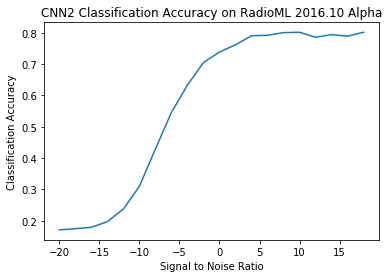

In [0]:

plt.plot(snrs, map(lambda x: acc[x], snrs));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");

In [0]:
Xd.keys()

[('QPSK', 2),
 ('PAM4', 8),
 ('AM-DSB', -4),
 ('GFSK', 6),
 ('QAM64', 8),
 ('AM-SSB', 12),
 ('PAM4', 18),
 ('QAM64', -6),
 ('QAM16', 2),
 ('QAM16', -20),
 ('8PSK', -18),
 ('PAM4', -6),
 ('WBFM', -18),
 ('BPSK', 8),
 ('CPFSK', 10),
 ('WBFM', 6),
 ('BPSK', 4),
 ('BPSK', -2),
 ('QPSK', -20),
 ('CPFSK', -8),
 ('AM-SSB', 6),
 ('QAM64', -20),
 ('QAM16', 12),
 ('GFSK', -20),
 ('AM-SSB', -12),
 ('CPFSK', 0),
 ('AM-DSB', 6),
 ('BPSK', -16),
 ('QPSK', -6),
 ('8PSK', -12),
 ('CPFSK', -18),
 ('AM-DSB', -18),
 ('QPSK', 8),
 ('PAM4', 14),
 ('WBFM', -8),
 ('AM-DSB', -10),
 ('GFSK', 12),
 ('QAM64', 2),
 ('8PSK', -10),
 ('AM-SSB', -18),
 ('QAM64', -4),
 ('GFSK', -4),
 ('AM-DSB', 8),
 ('PAM4', -16),
 ('QPSK', -16),
 ('BPSK', 16),
 ('WBFM', -14),
 ('CPFSK', 16),
 ('WBFM', 0),
 ('QPSK', 6),
 ('BPSK', 14),
 ('AM-DSB', -8),
 ('GFSK', -10),
 ('CPFSK', -2),
 ('AM-SSB', 8),
 ('QAM16', 8),
 ('QAM16', 6),
 ('QAM16', -16),
 ('QAM64', 18),
 ('AM-SSB', -2),
 ('CPFSK', 6),
 ('BPSK', 0),
 ('BPSK', -6),
 ('8PSK', -14)

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')